In [1]:
!pip install pandas

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
import missingno as msno

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Loan_Default_Prediction/Data")
#点击下方连接，得到授权码，输入到下方空白栏出，授权使用云盘中的数据

Mounted at /content/drive


In [4]:
train_data = pd.read_csv('./train.csv', sep = ',')
test_data = pd.read_csv('./testA.csv', sep = ',')

In [27]:
train_data.head()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,issueDate,isDefault,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,earliesCreditLine,title,policyCode,n0,n1,n2,n2.1,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,35000.0,5,19.52,917.97,E,E2,320.0,2 years,2,110000.0,2,2014-07-01,1,1,137.0,32,17.05,0.0,730.0,734.0,7.0,0.0,0.0,24178.0,48.9,27.0,0,0,Aug-2001,1.0,1.0,0.0,2.0,2.0,2.0,4.0,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,1,18000.0,5,18.49,461.90,D,D2,219843.0,5 years,0,46000.0,2,2012-08-01,0,0,156.0,18,27.83,0.0,700.0,704.0,13.0,0.0,0.0,15096.0,38.9,18.0,1,0,May-2002,1723.0,1.0,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,2,12000.0,5,16.99,298.17,D,D3,31698.0,8 years,0,74000.0,2,2015-10-01,0,0,337.0,14,22.77,0.0,675.0,679.0,11.0,0.0,0.0,4606.0,51.8,27.0,0,0,May-2006,0.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,3,11000.0,3,7.26,340.96,A,A4,46854.0,10+ years,1,118000.0,1,2015-08-01,0,4,148.0,11,17.21,0.0,685.0,689.0,9.0,0.0,0.0,9948.0,52.6,28.0,1,0,May-1999,4.0,1.0,6.0,4.0,6.0,6.0,4.0,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,4,3000.0,3,12.99,101.07,C,C2,54.0,NaN,1,29000.0,2,2016-03-01,0,10,301.0,21,32.16,0.0,690.0,694.0,12.0,0.0,0.0,2942.0,32.0,27.0,0,0,Aug-1977,11.0,1.0,1.0,2.0,7.0,7.0,2.0,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0


## 1.EDA 

In [5]:
train_data.shape
test_data.shape

(200000, 48)

In [9]:
train_data.columns

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',
       'annualIncome', 'verificationStatus', 'issueDate', 'isDefault',
       'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n2.1', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n11', 'n12', 'n13', 'n14'],
      dtype='object')

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  800000 non-null  int64  
 1   loanAmnt            800000 non-null  float64
 2   term                800000 non-null  int64  
 3   interestRate        800000 non-null  float64
 4   installment         800000 non-null  float64
 5   grade               800000 non-null  object 
 6   subGrade            800000 non-null  object 
 7   employmentTitle     799999 non-null  float64
 8   employmentLength    753201 non-null  object 
 9   homeOwnership       800000 non-null  int64  
 10  annualIncome        800000 non-null  float64
 11  verificationStatus  800000 non-null  int64  
 12  issueDate           800000 non-null  object 
 13  isDefault           800000 non-null  int64  
 14  purpose             800000 non-null  int64  
 15  postCode            799999 non-nul

In [12]:
train_data['employmentTitle'].value_counts()

54.0        51149
38.0        12644
32.0        11543
184.0        6112
151.0        5193
            ...  
311225.0        1
13438.0         1
311224.0        1
311223.0        1
269398.0        1
Name: employmentTitle, Length: 248683, dtype: int64

In [13]:
train_data['term'].value_counts()

3    606902
5    193098
Name: term, dtype: int64

### 1.1特征分类

In [32]:

# employmentTitle 可以用数据类型特征/分箱后作为分类类型特征,暂时用前者方法处理
# issueDate 日期类型信息
# earliesCreditLine 可转为日期类型信息
feature_columns = ['loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',
       'annualIncome', 'verificationStatus', 'issueDate', 
       'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n2.1', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n11', 'n12', 'n13', 'n14']      


numerical_fea = ['loanAmnt', 'term', 'interestRate', 'installment', 
        'employmentTitle',  'annualIncome',  'issueDate', 
        'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n2.1', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n11', 'n12', 'n13', 'n14']
categorical_fea = ['grade','subGrade','employmentLength','homeOwnership','verificationStatus','purpose']

num_fea = list(train_data.select_dtypes(exclude=['object']).columns)
cat_fea = list(filter(lambda x: x not in numerical_fea,feature_columns))
# num_fea = ['loanAmnt', 'term', 'interestRate', 'installment', 'employmentTitle', 'homeOwnership',
#        'annualIncome', 'verificationStatus',
#        'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
#        'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
#        'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
#        'initialListStatus', 'applicationType', 'title',
#        'policyCode', 'n0', 'n1', 'n2', 'n2.1', 'n4', 'n5', 'n6', 'n7', 'n8',
#        'n9', 'n10', 'n11', 'n12', 'n13', 'n14']
# cat_fea = ['grade','subGrade','employmentLength',]       
X_data = train_data[feature_columns]
Y_data = train_data['isDefault']

### 1.2数据分布

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


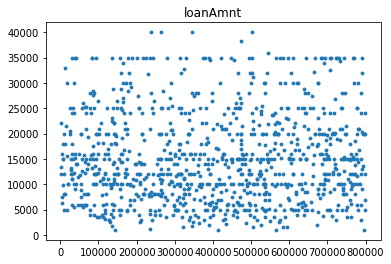

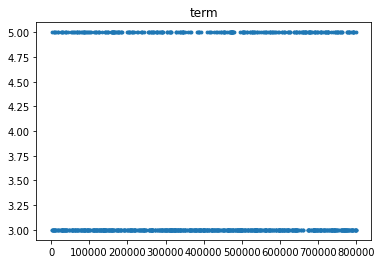

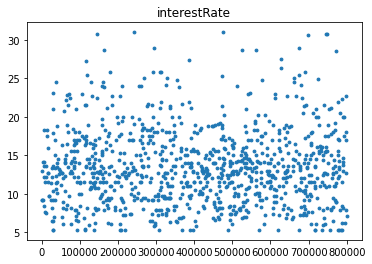

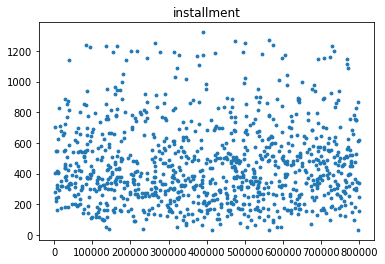

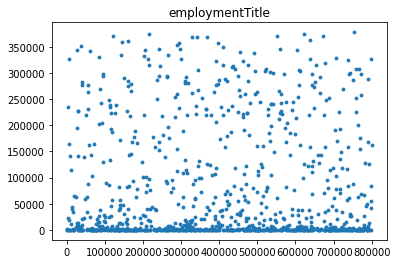

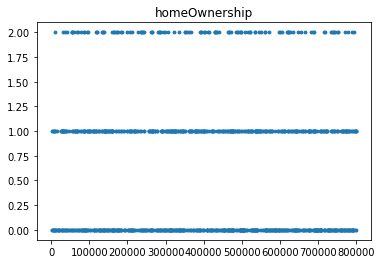

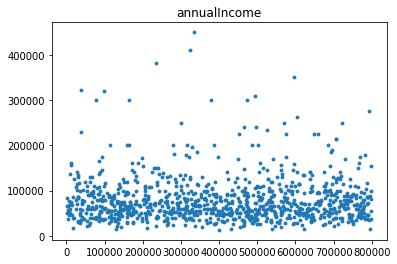

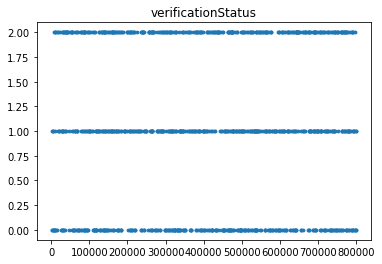

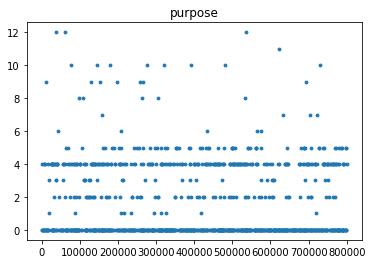

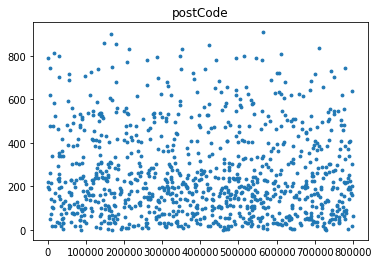

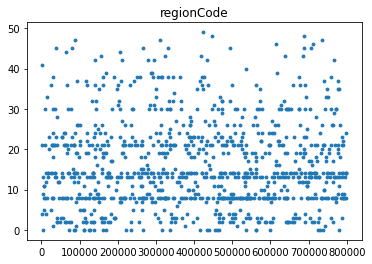

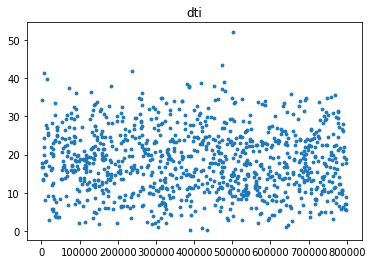

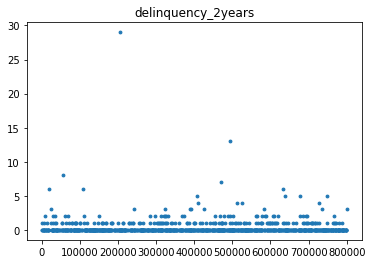

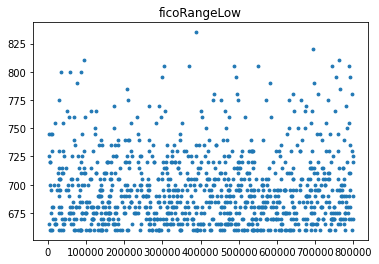

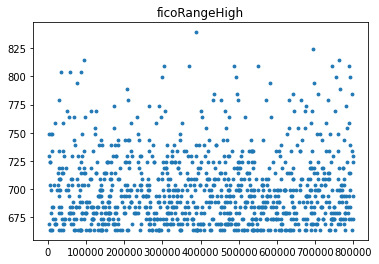

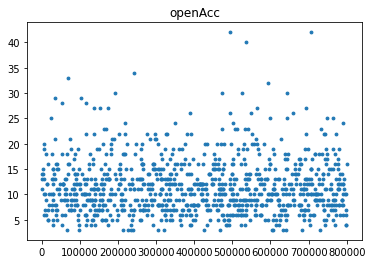

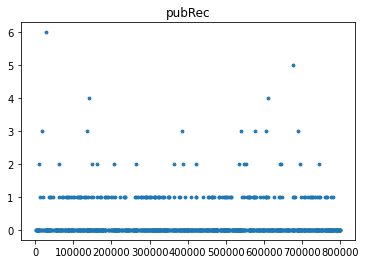

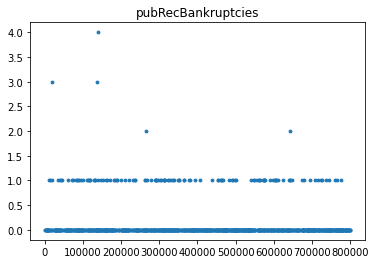

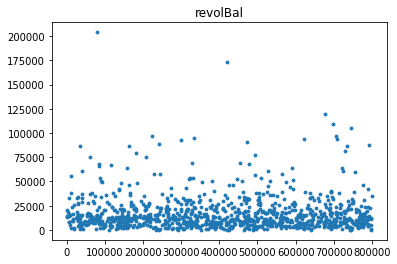

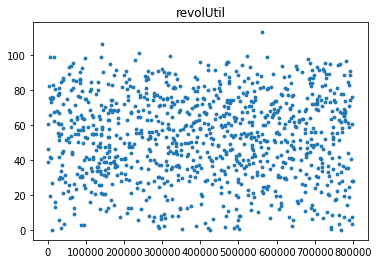

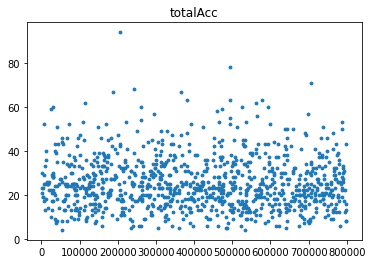

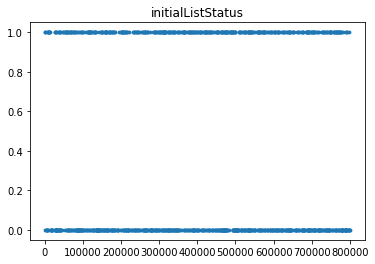

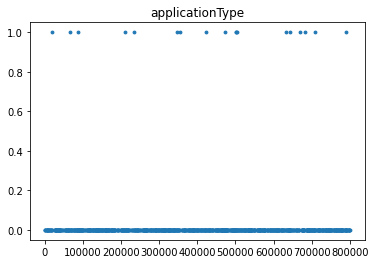

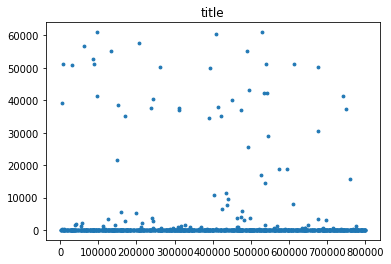

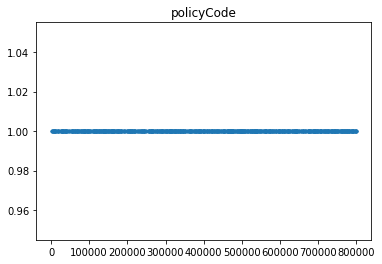

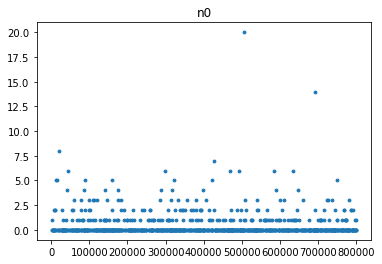

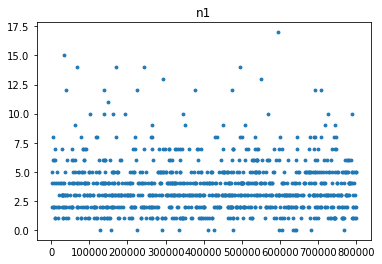

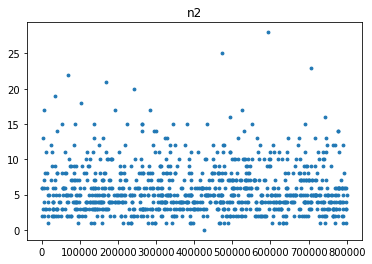

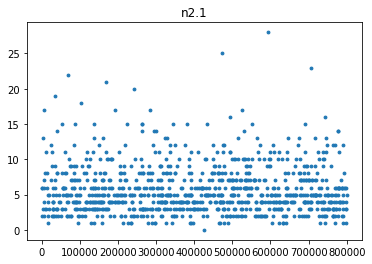

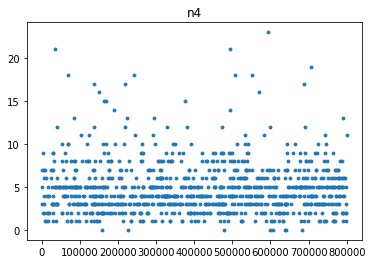

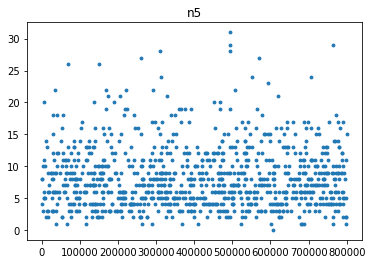

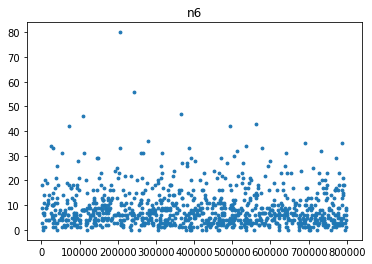

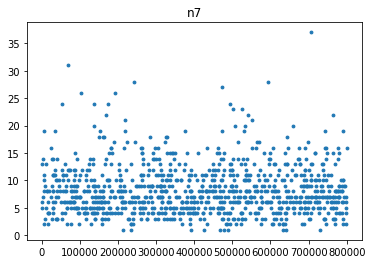

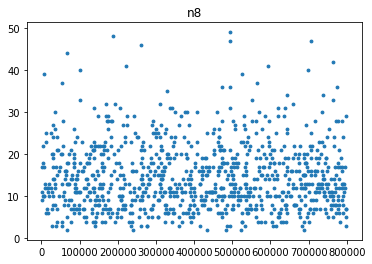

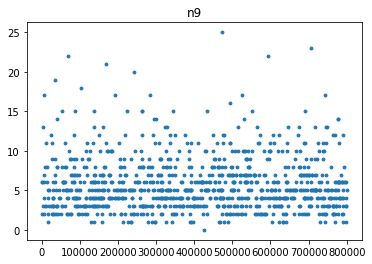

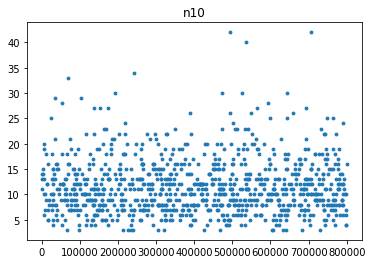

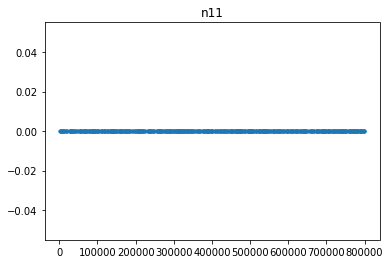

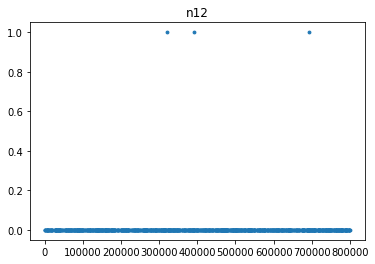

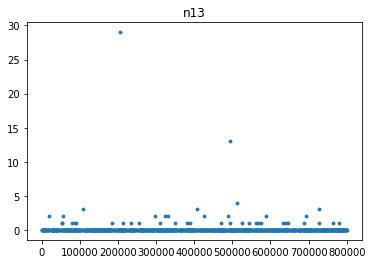

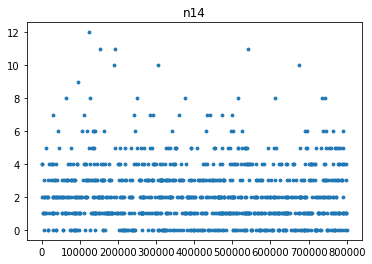

In [31]:
sample = train_data.sample(1000)
# 查看Numerical features的分布情况，离散还是连续
for feas in num_fea:
  plt.figure(figsize = (6,4))
  plt.title(feas)
  plt.scatter(sample['id'], sample[feas], s = 8)



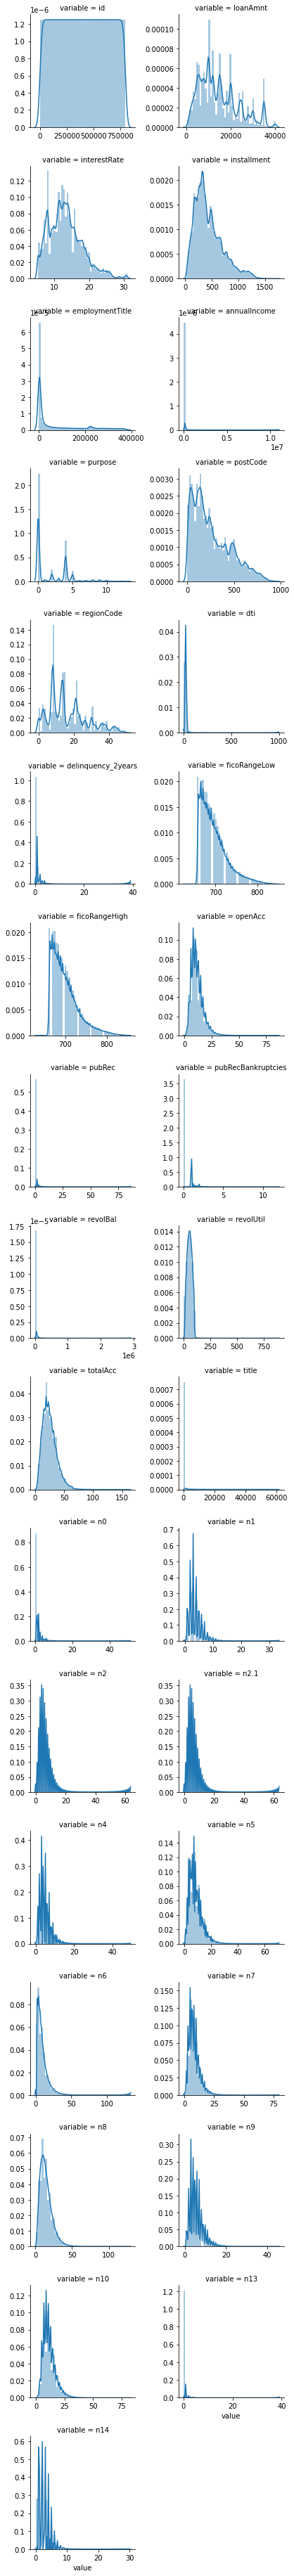

In [34]:
#过滤数值型类别特征
def get_numerical_serial_fea(data,feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []
    for fea in feas:
        temp = data[fea].nunique()
        if temp <= 10:
            numerical_noserial_fea.append(fea)
            continue
        numerical_serial_fea.append(fea)
    return numerical_serial_fea,numerical_noserial_fea
numerical_serial_fea,numerical_noserial_fea = get_numerical_serial_fea(train_data,num_fea)

#每个数字特征得分布可视化
f = pd.melt(train_data, value_vars=numerical_serial_fea)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

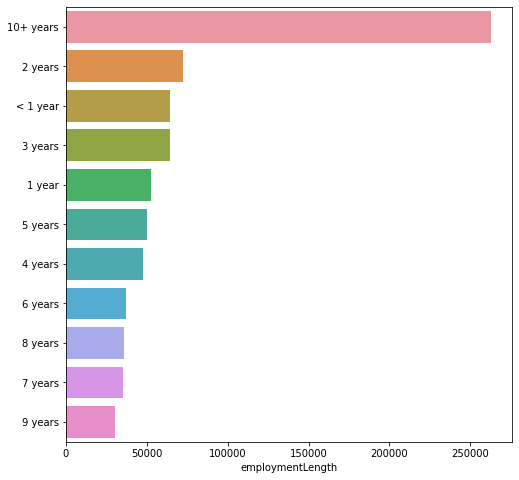

In [35]:
# 变量分布可视化
plt.figure(figsize=(8, 8))
sns.barplot(train_data["employmentLength"].value_counts(dropna=False)[:20],
            train_data["employmentLength"].value_counts(dropna=False).keys()[:20])
plt.show()

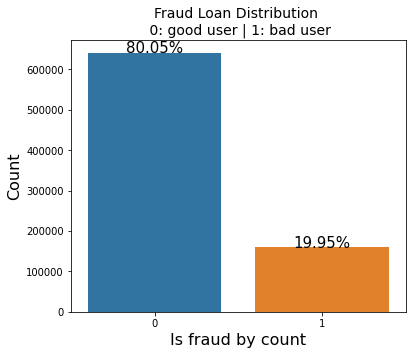

In [38]:
# 正负样本比例
total = len(train_data)
total_amt = train_data.groupby(['isDefault'])['loanAmnt'].sum().sum()
plt.figure(figsize=(6,5))
plot_tr = sns.countplot(x='isDefault',data=train_data)#train data‘isDefault’这个特征每种类别的数量**
plot_tr.set_title("Fraud Loan Distribution \n 0: good user | 1: bad user", fontsize=14)
plot_tr.set_xlabel("Is fraud by count", fontsize=16)
plot_tr.set_ylabel('Count', fontsize=16)
for p in plot_tr.patches:
    height = p.get_height()
    plot_tr.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

### 1.3 时间格式处理

In [41]:
import datetime
# issueDate需要转换为datetime类型
train_data['issueDate'] = pd.to_datetime(train_data['issueDate'],format='%Y-%m-%d')
startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
train_data['issueDateDT'] = train_data['issueDate'].apply(lambda x: x-startdate).dt.days

In [42]:
test_data['issueDate'] = pd.to_datetime(test_data['issueDate'],format='%Y-%m-%d')
startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
test_data['issueDateDT'] = test_data['issueDate'].apply(lambda x: x-startdate).dt.days

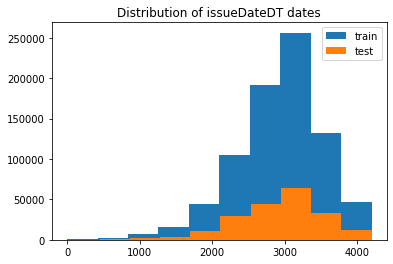

In [43]:
plt.hist(train_data['issueDateDT'], label='train');
plt.hist(test_data['issueDateDT'], label='test');
plt.legend();
plt.title('Distribution of issueDateDT dates');

In [44]:
pivot = pd.pivot_table(train_data, index=['grade'], columns=['issueDateDT'], values=['loanAmnt'], aggfunc=np.sum)

In [45]:
pivot

loanAmnt                    ...                                 
issueDateDT     0        30       61    ...       4140       4171       4201
grade                                   ...                                 
A                NaN  53650.0  42000.0  ...  3919275.0  2694025.0  2245625.0
B                NaN  13000.0  24000.0  ...  4329400.0  3922575.0  3257100.0
C                NaN  68750.0   8175.0  ...  4552600.0  2870050.0  2246250.0
D                NaN      NaN   5500.0  ...  3038500.0  2452375.0  1771750.0
E             7500.0      NaN  10000.0  ...  1131625.0   883950.0   802425.0
F                NaN      NaN  31250.0  ...   315075.0    72300.0        NaN
G                NaN      NaN      NaN  ...    23750.0    25100.0     1000.0

[7 rows x 139 columns]

### 缺失值

In [8]:
train_data.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           1
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  1
regionCode                0
dti                     239
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      405
revolBal                  0
revolUtil               531
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     1
policyCode                0
n0                    40270
n1                    40270
n2                    40270
n2.1                

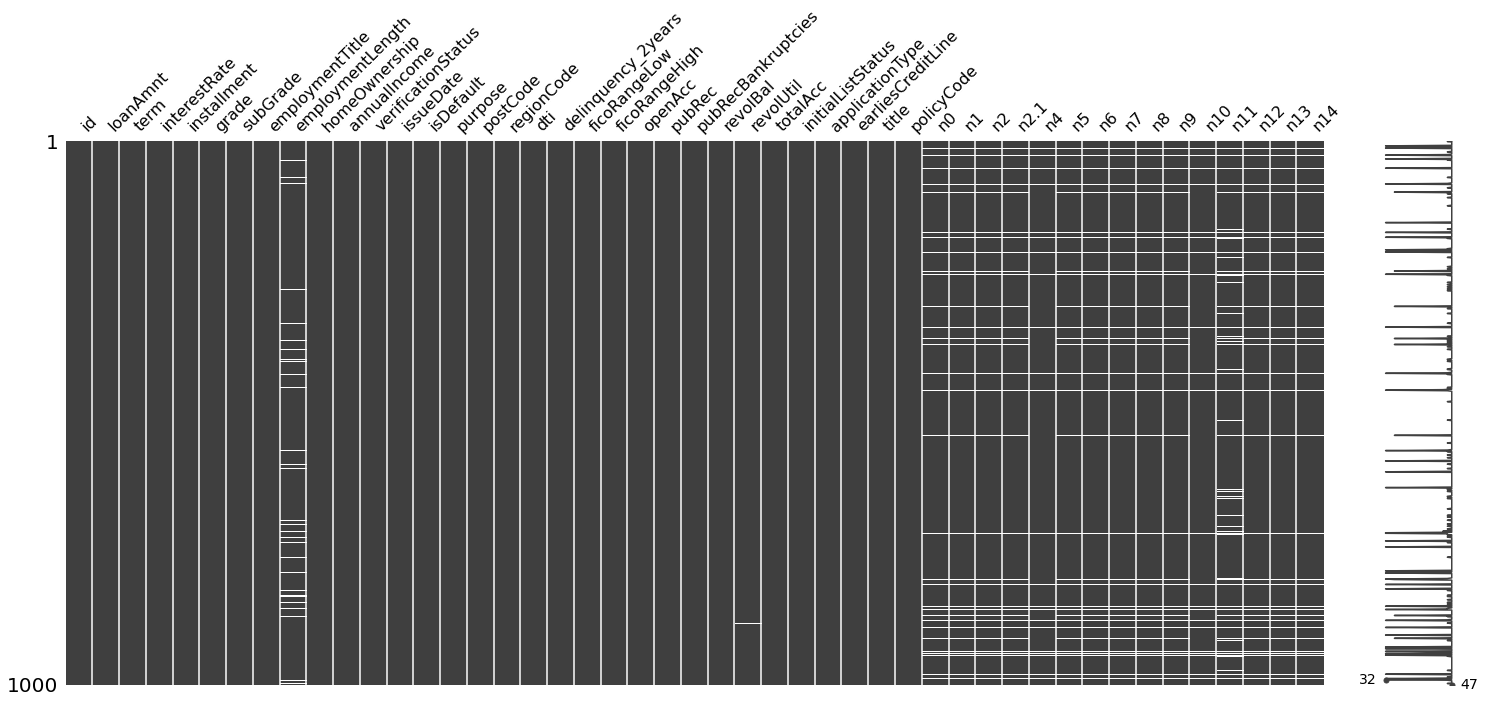

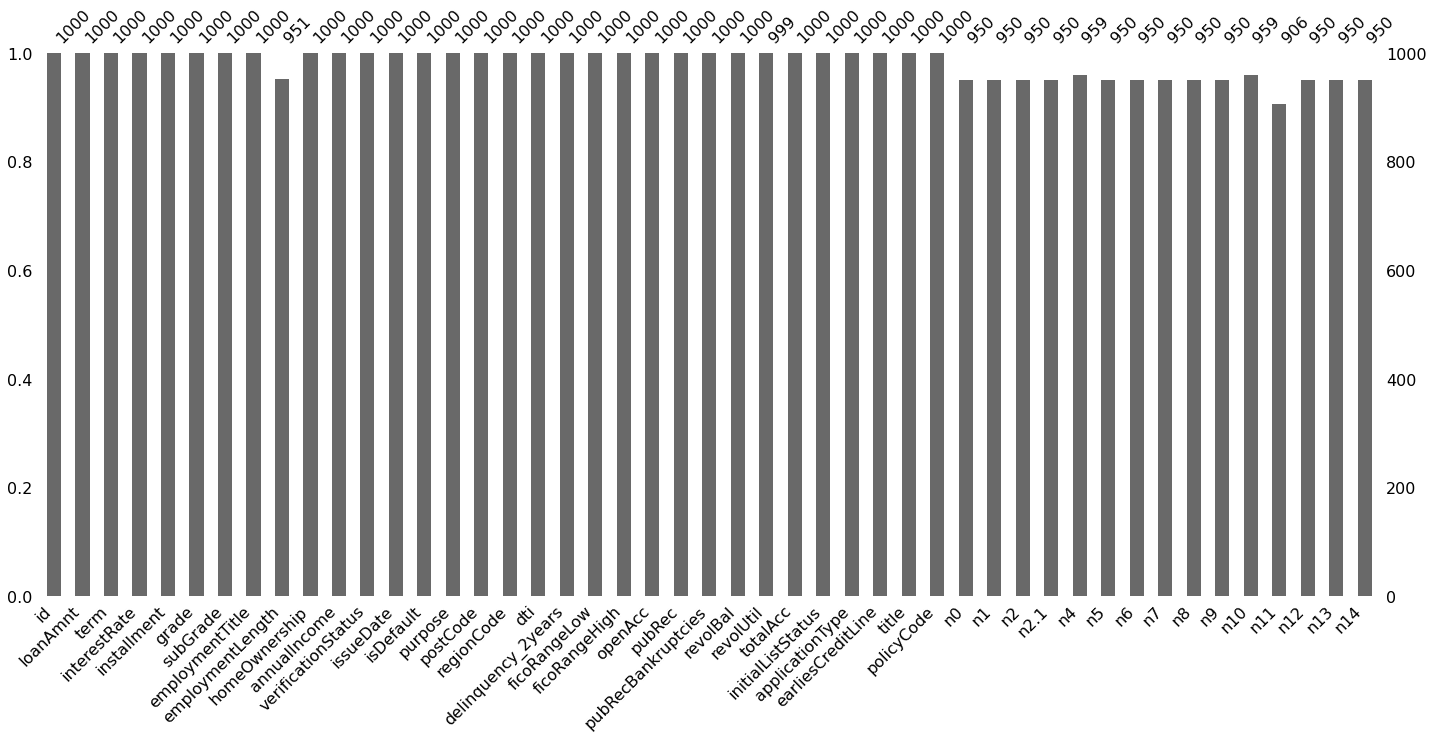

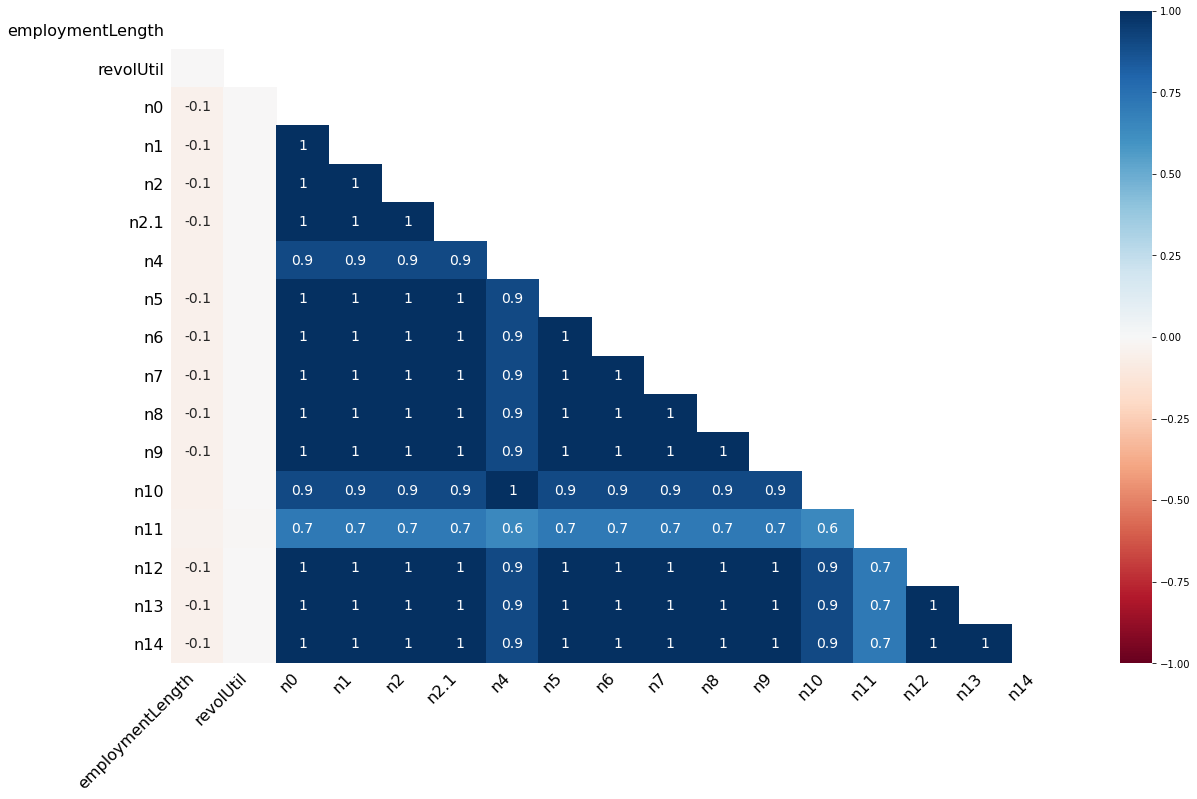

In [11]:
sample = train_data.sample(1000)
msno.matrix(sample)
plt.show()
msno.bar(sample)
plt.show()
msno.heatmap(sample)
plt.show()

In [ ]:
# 输出结果
sub = pd.DataFrame()
sub['id'] = test_data.id
sub['isDefault'] = predict_y
#sub['price'] = np.exp(predict_y)
sub.to_csv('./result.csv', index = False)